In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'FORTUM.HE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,1208,-551,657,312,2989,852,237,4460,256,...,23673,0,0,924,1991,6903,11563,566,-123,888.3
1,2014-06-30,886,-388,498,197,2157,597,262,3331,265,...,22030,0,0,338,1228,6828,10606,456,-134,888.3
2,2014-09-30,861,-414,447,58,2178,588,257,3211,247,...,21640,0,0,1015,1853,5954,10385,288,-165,888.3
3,2014-12-31,1133,-473,660,523,2009,830,256,4301,170,...,21375,0,287,816,2067,5881,10511,452,-200,888.3
4,2015-03-31,1040,-433,607,295,1773,637,247,7212,197,...,22182,0,214,824,3698,5944,11761,603,-101,888.3


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,889.2,2407,-1368,1039,-611,3771,1767,465,...,407,23642,0,2831,1648,10122,3558,15972,607,-153
36,2023-03-31,2023-04-21,897.2,2264,-1246,1018,568,3688,1419,439,...,629,21334,0,767,1895,5791,3623,11609,583,-132
37,2023-06-30,2023-07-21,897.2,1368,-790,578,-3234,4156,851,322,...,606,18930,0,692,423,3979,5113,11248,658,-168
38,2023-09-30,2023-10-21,897.2,122,-665,-543,186,4552,831,322,...,643,18842,0,495,1035,3726,4409,10398,429,-146
39,2023-12-31,2024-02-11,897.2,1858,-1106,752,412,4183,1286,452,...,394,18739,0,507,961,3708,4476,10300,149,-130


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,889.2,2407,-1368,1039,-611,3771,1767,465,...,23642,0,2831,1648,10122,3558,15972,607,-153,0.980663
36,2023-03-31,2023-04-21,897.2,2264,-1246,1018,568,3688,1419,439,...,21334,0,767,1895,5791,3623,11609,583,-132,0.932003
37,2023-06-30,2023-07-21,897.2,1368,-790,578,-3234,4156,851,322,...,18930,0,692,423,3979,5113,11248,658,-168,0.918362
38,2023-09-30,2023-10-21,897.2,122,-665,-543,186,4552,831,322,...,18842,0,495,1035,3726,4409,10398,429,-146,0.918837
39,2023-12-31,2024-02-11,897.2,1858,-1106,752,412,4183,1286,452,...,18739,0,507,961,3708,4476,10300,149,-130,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,889.2,2407,-1368,1039,-611,3771,1767,465,...,23642,0,2831,1648,10122,3558,15972,607,-153,0.980663
36,2023-03-31,2023-04-21,897.2,2264,-1246,1018,568,3688,1419,439,...,21334,0,767,1895,5791,3623,11609,583,-132,0.932003
37,2023-06-30,2023-07-21,897.2,1368,-790,578,-3234,4156,851,322,...,18930,0,692,423,3979,5113,11248,658,-168,0.918362
38,2023-09-30,2023-10-21,897.2,122,-665,-543,186,4552,831,322,...,18842,0,495,1035,3726,4409,10398,429,-146,0.918837
39,2023-12-31,2024-02-11,897.2,1858,-1106,752,412,4183,1286,452,...,18739,0,507,961,3708,4476,10300,149,-130,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,8.577423,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,0.511553,0.488447,5.671362,inf,1.616594,9.299578,0.543874,0.258278,0.052718,0.103055
1,2014-04-28,8.876004,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,0.511553,0.488447,5.671362,inf,1.616594,9.299578,0.543874,0.258278,0.052718,0.103055
2,2014-05-05,9.310302,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,0.511553,0.488447,5.671362,inf,1.616594,9.299578,0.543874,0.258278,0.052718,0.103055
3,2014-05-12,9.603456,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,0.511553,0.488447,5.671362,inf,1.616594,9.299578,0.543874,0.258278,0.052718,0.103055
4,2014-05-19,9.592598,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,0.511553,0.488447,5.671362,inf,1.616594,9.299578,0.543874,0.258278,0.052718,0.103055


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,8.577423,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,9.299578,0.543874,0.258278,0.052718,0.103055,6.105228,0.629176,1.576847,3.351268,2.764632
1,2014-04-28,8.876004,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,9.299578,0.543874,0.258278,0.052718,0.103055,6.317752,0.651078,1.631737,3.406158,2.860869
2,2014-05-05,9.310302,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,9.299578,0.543874,0.258278,0.052718,0.103055,6.626876,0.682935,1.711577,3.485998,3.000849
3,2014-05-12,9.603456,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,9.299578,0.543874,0.258278,0.052718,0.103055,6.835537,0.704439,1.765470,3.539890,3.095338
4,2014-05-19,9.592598,2014-03-31,1208.0,1.404931,13.632782,888.3,2756.0,3.102555,2989.0,...,9.299578,0.543874,0.258278,0.052718,0.103055,6.827808,0.703642,1.763474,3.537894,3.091838


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

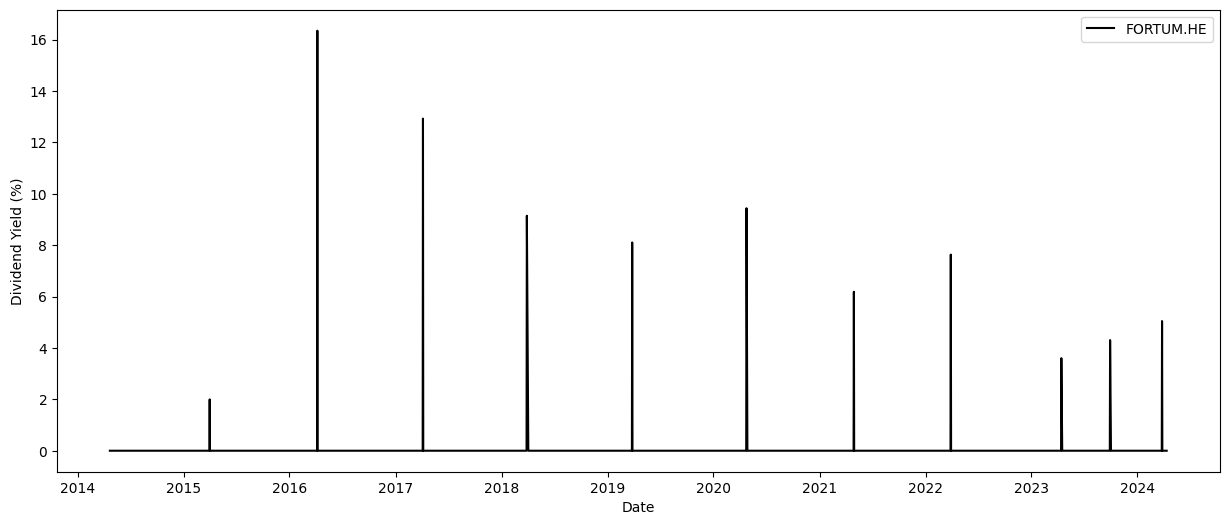

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.161345
share_price      1.000000
Name: share_price, dtype: float64


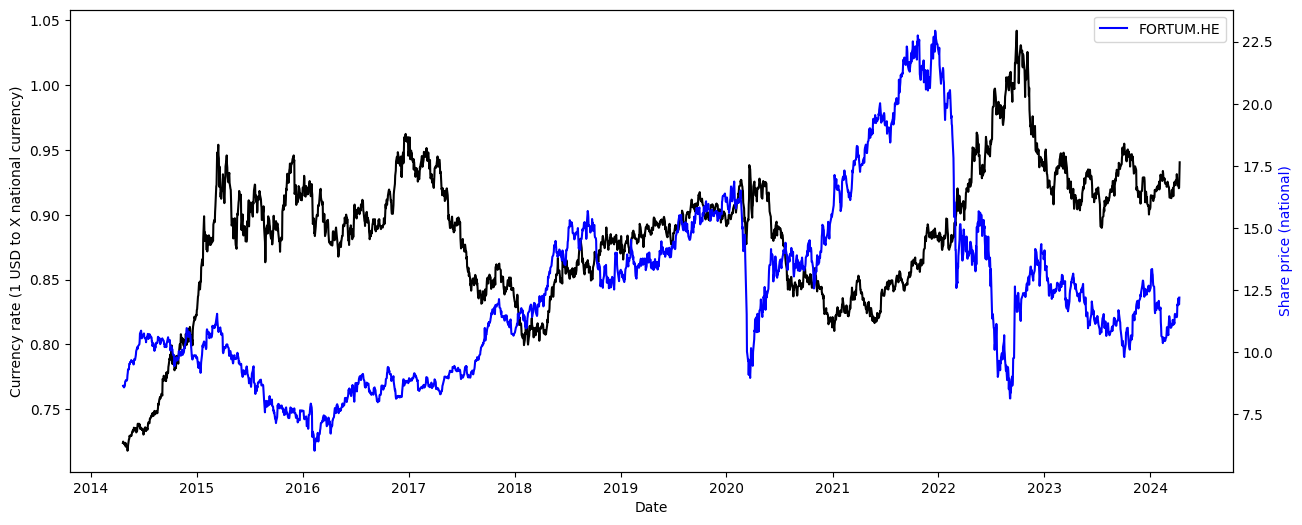

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

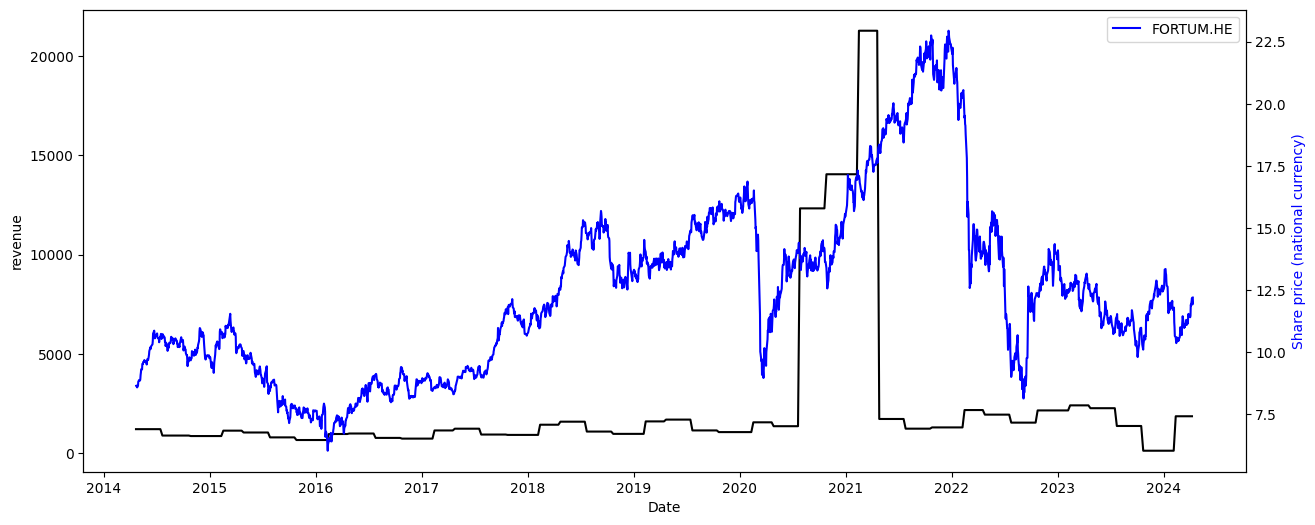

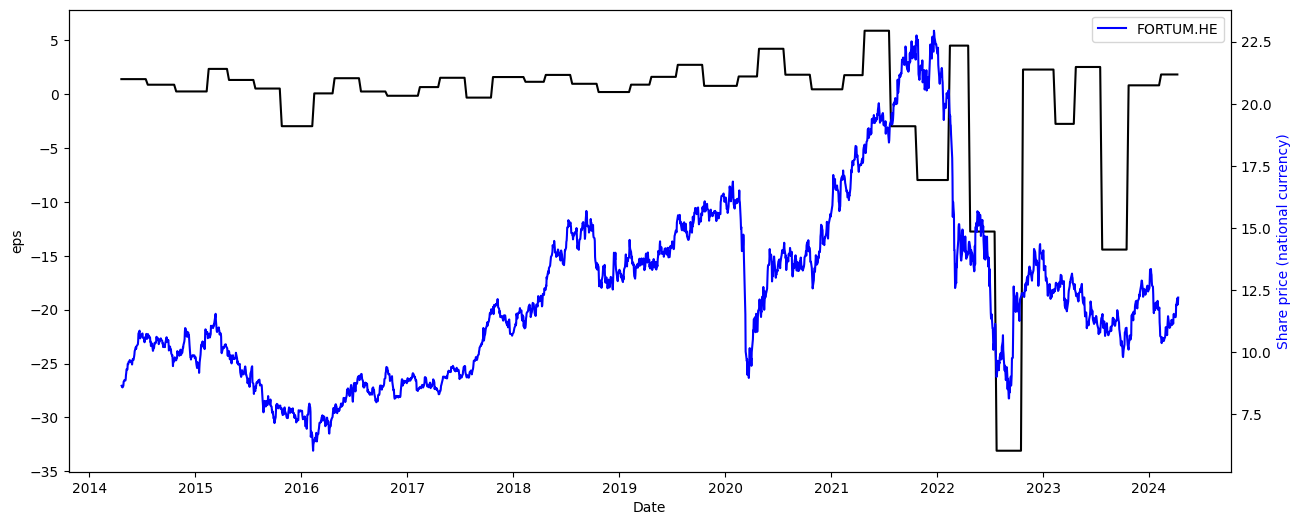

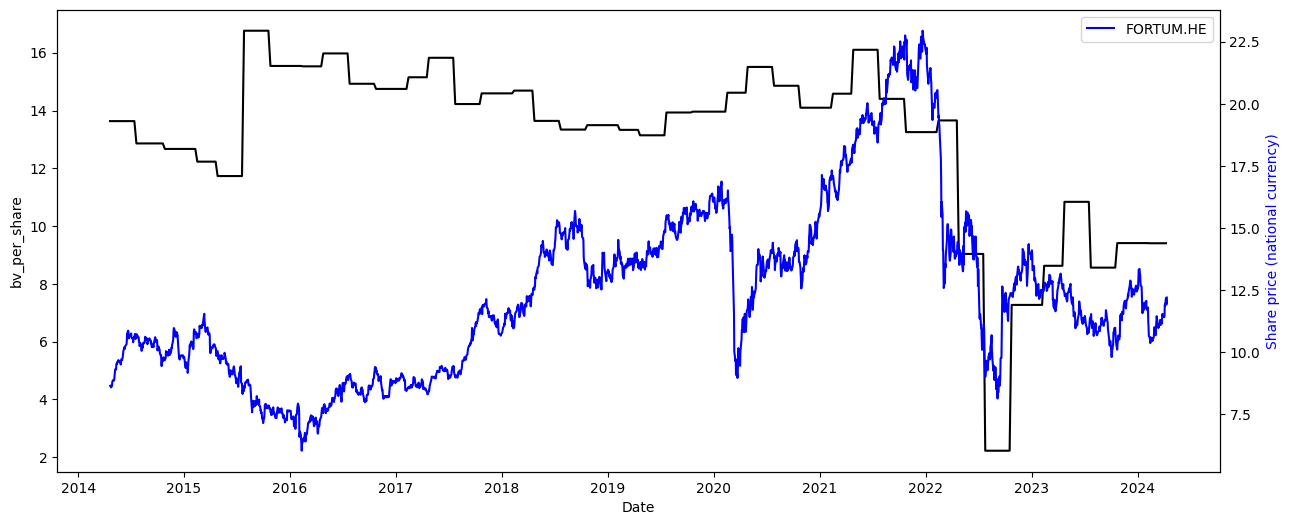

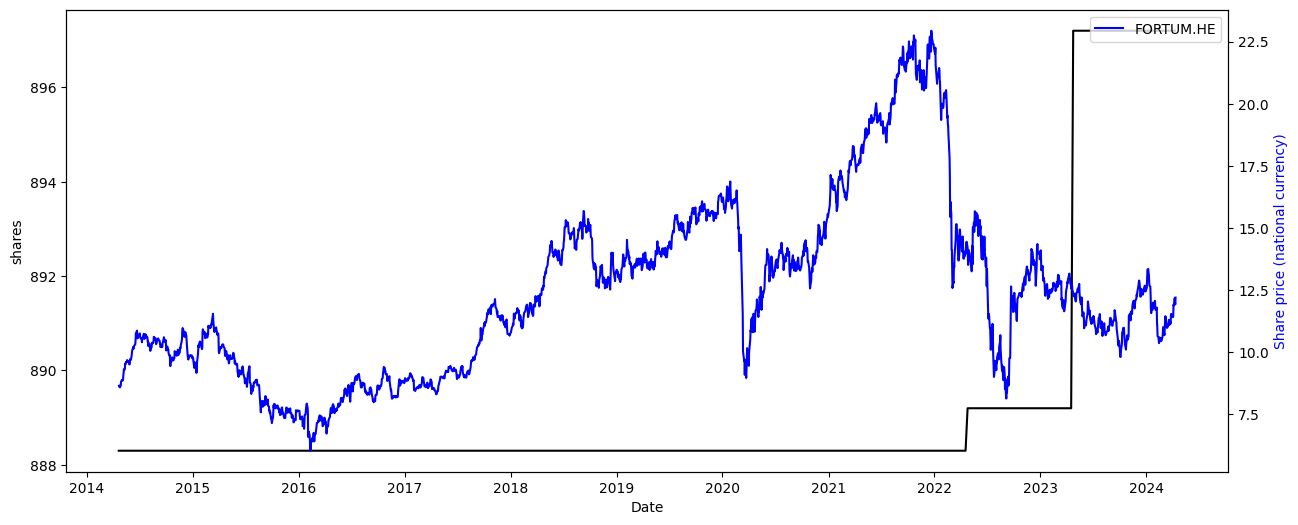

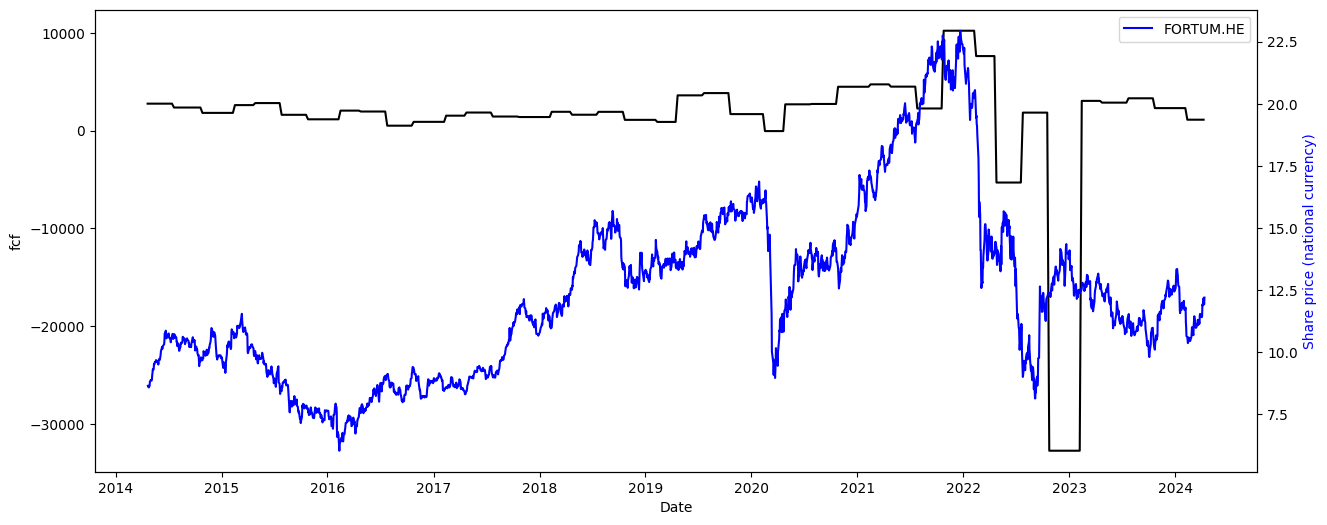

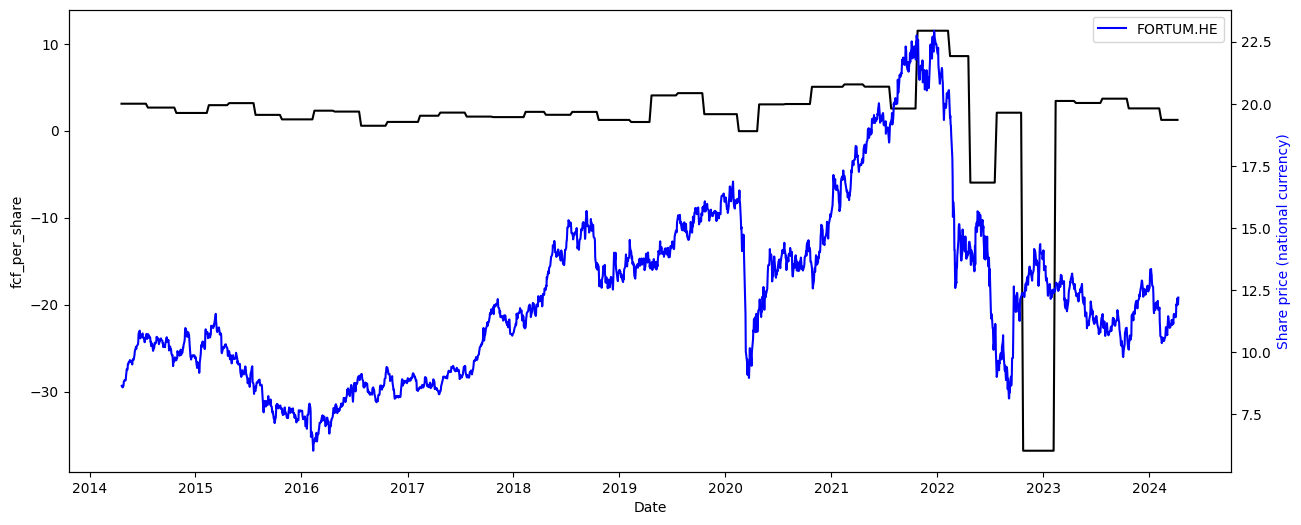

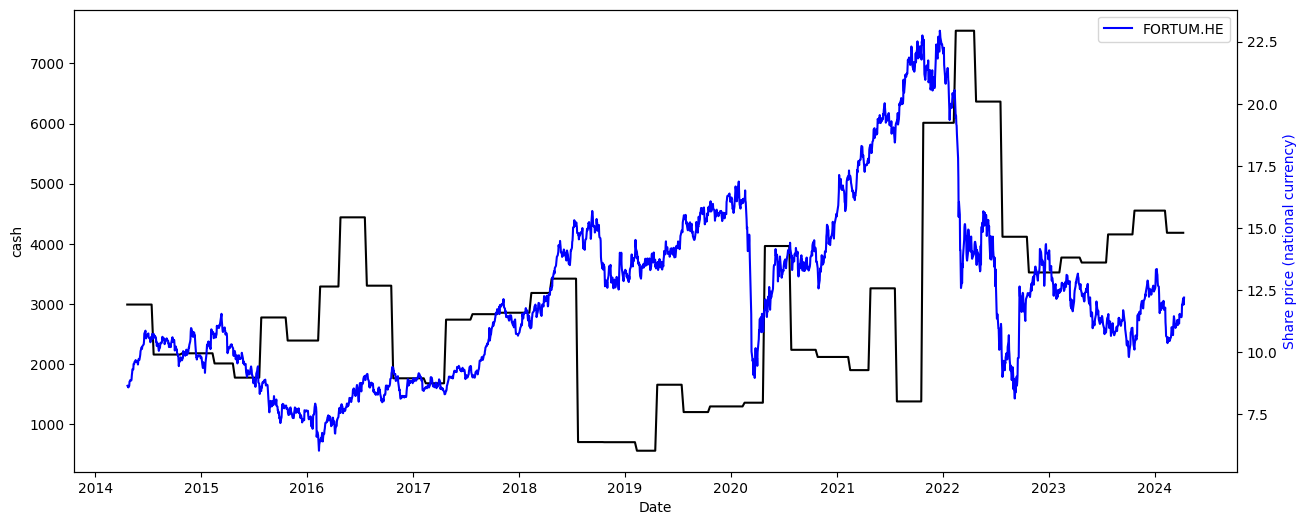

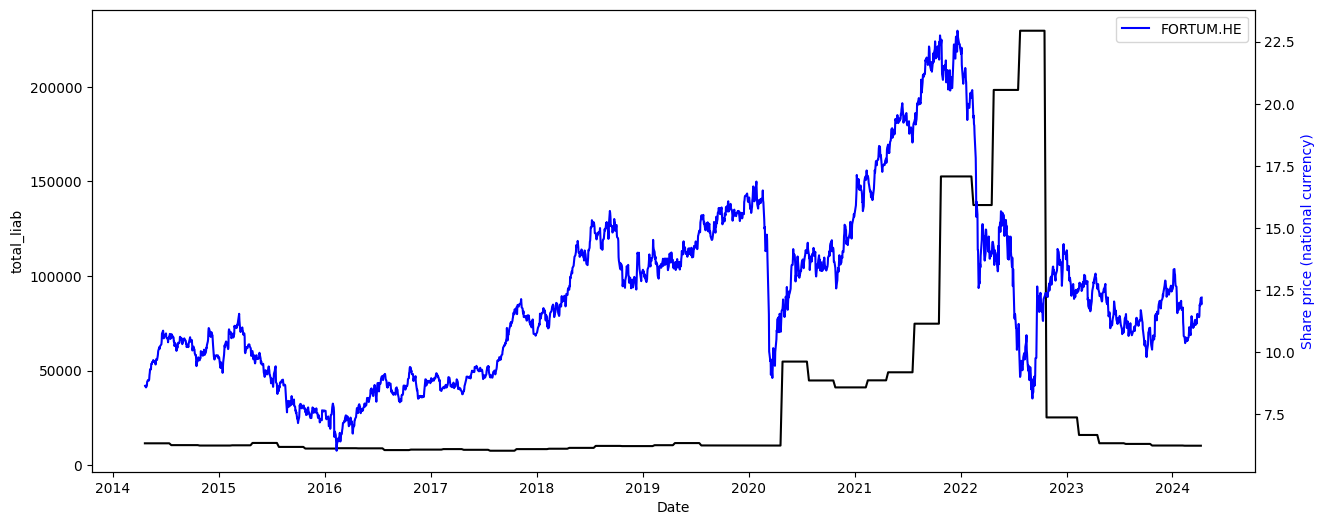

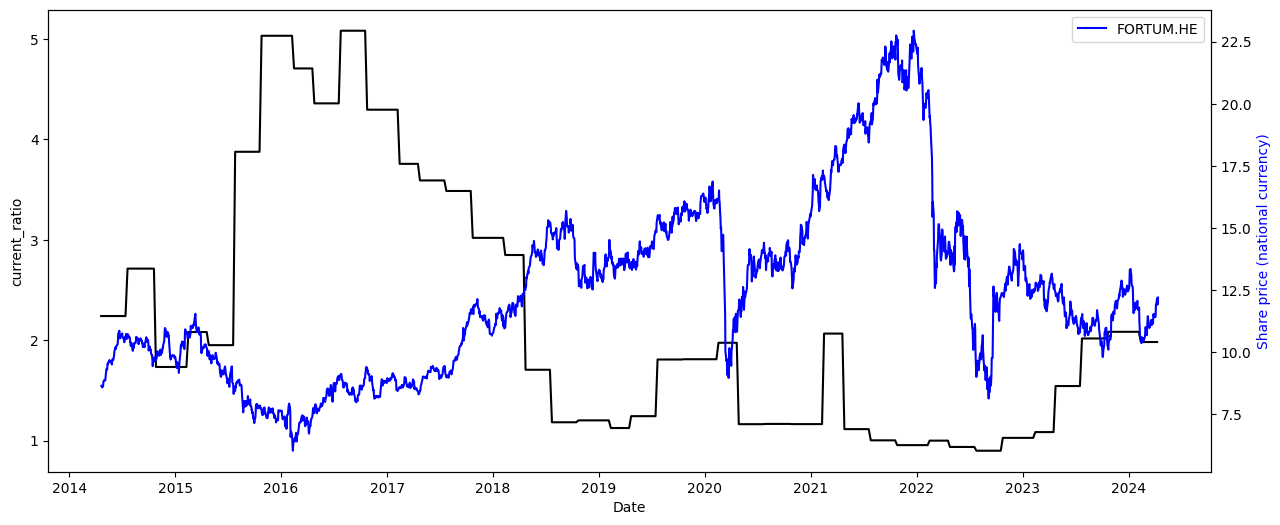

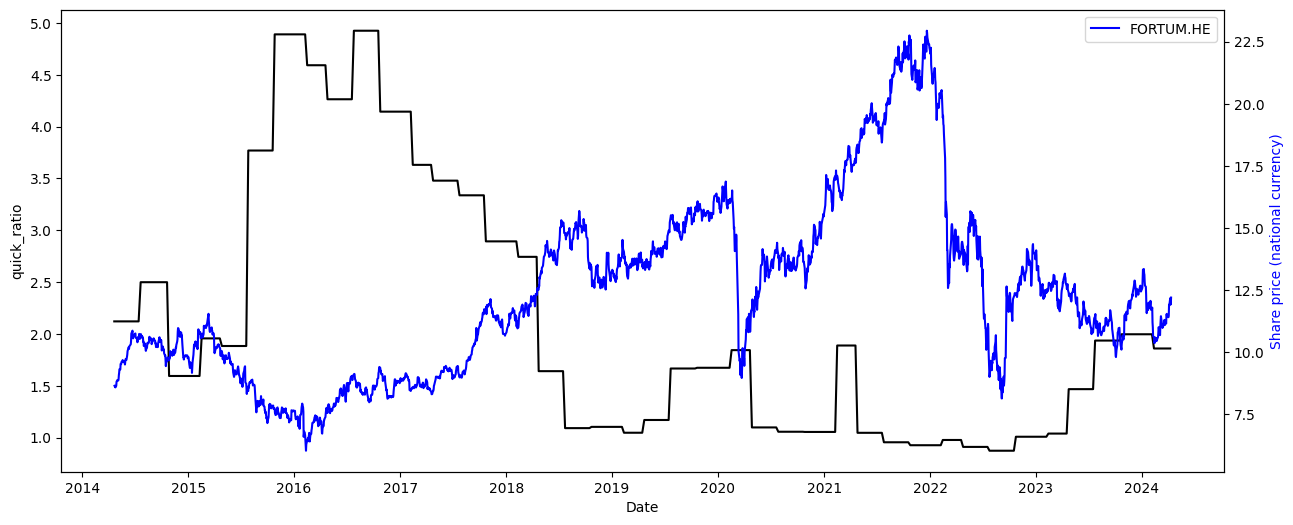

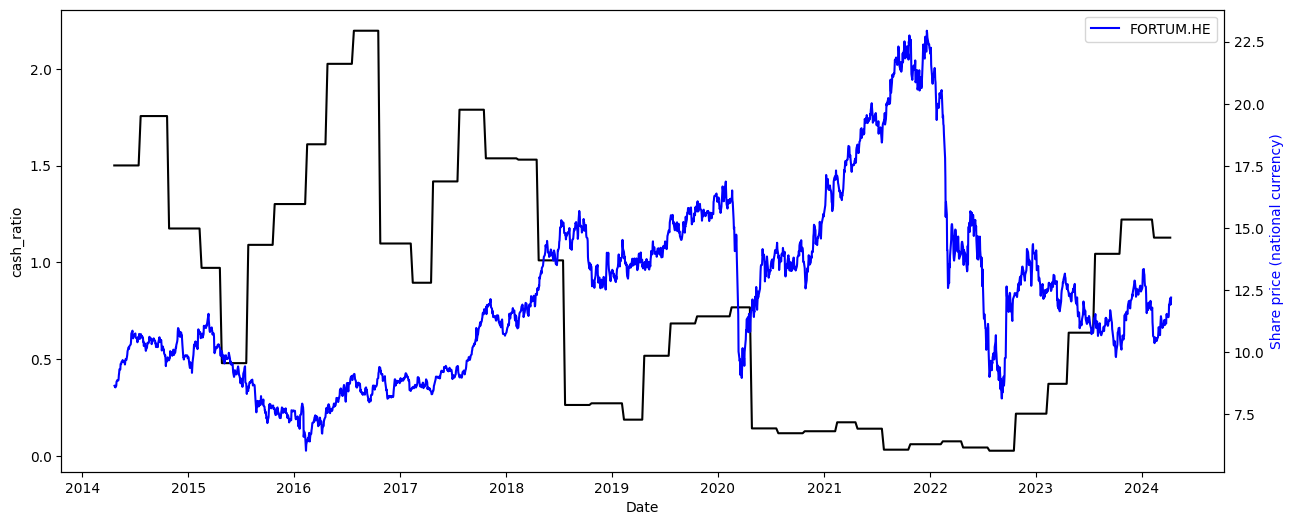

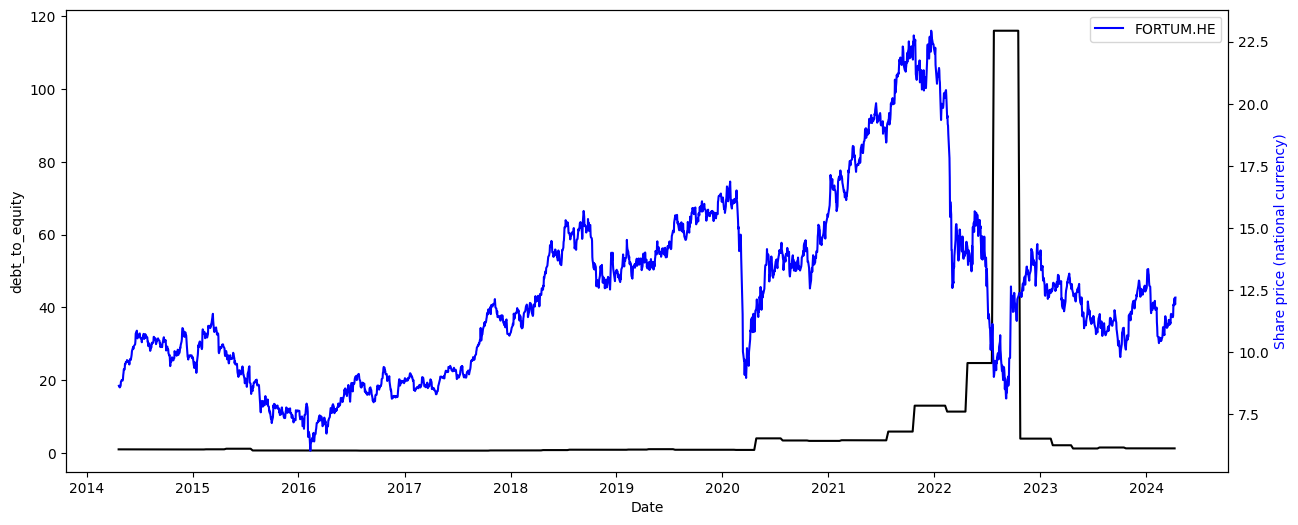

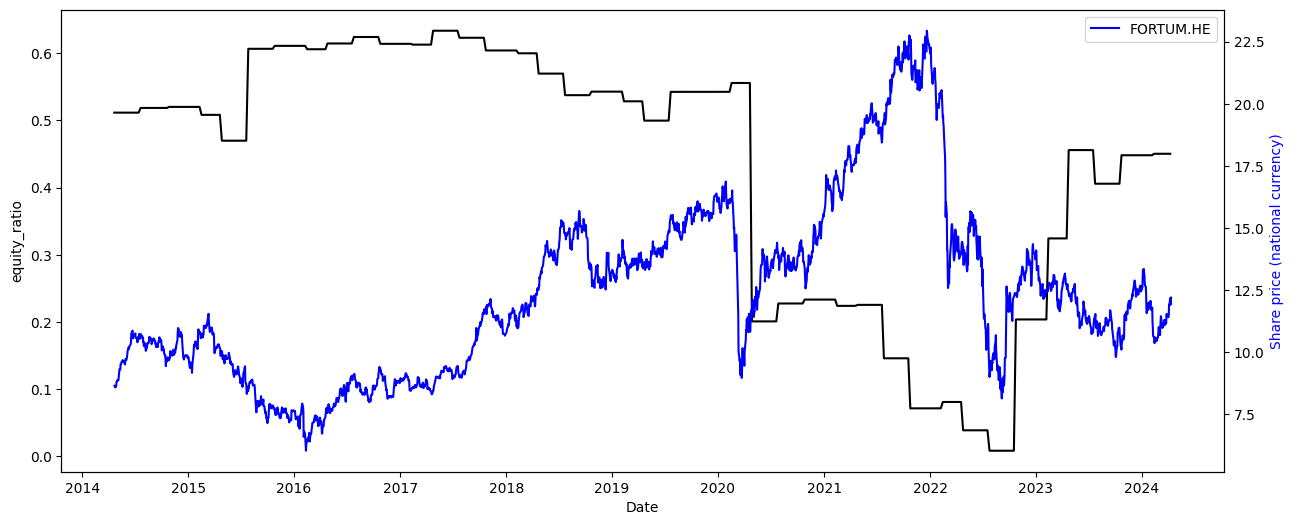

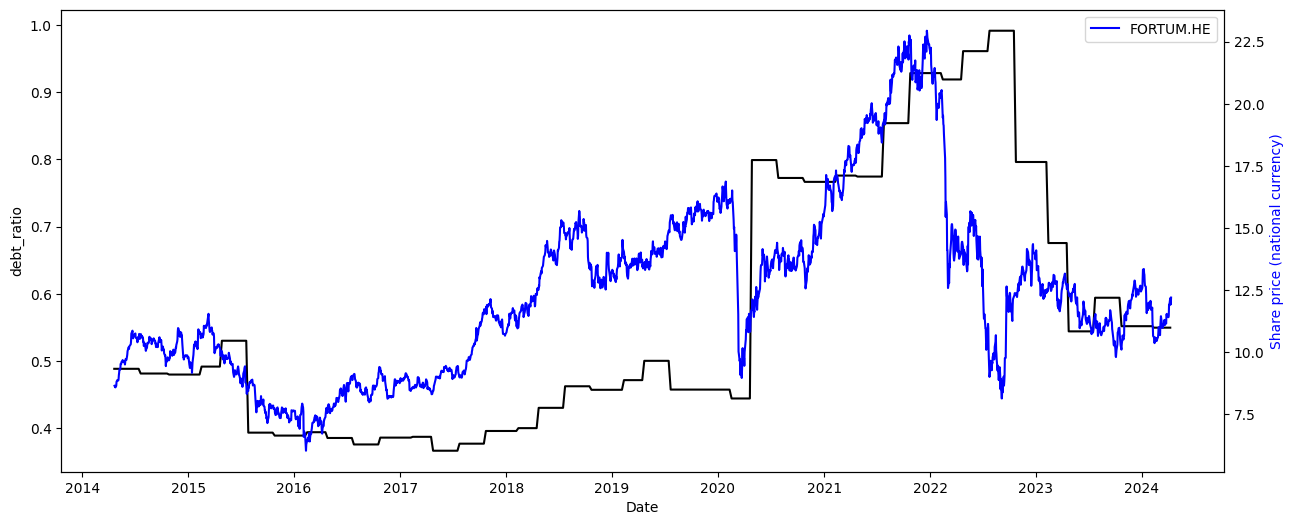

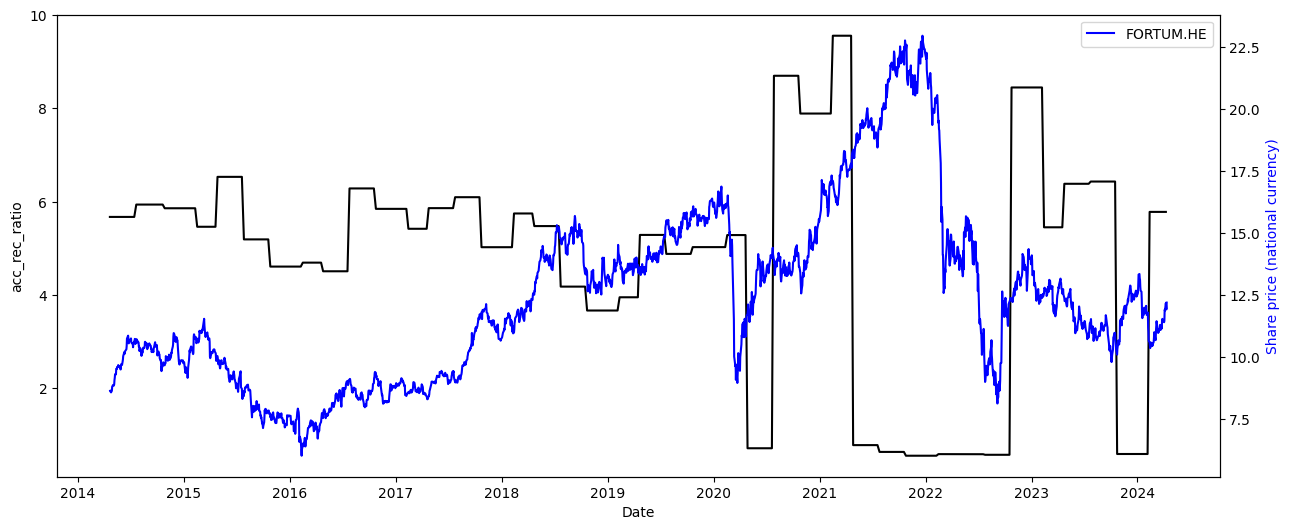

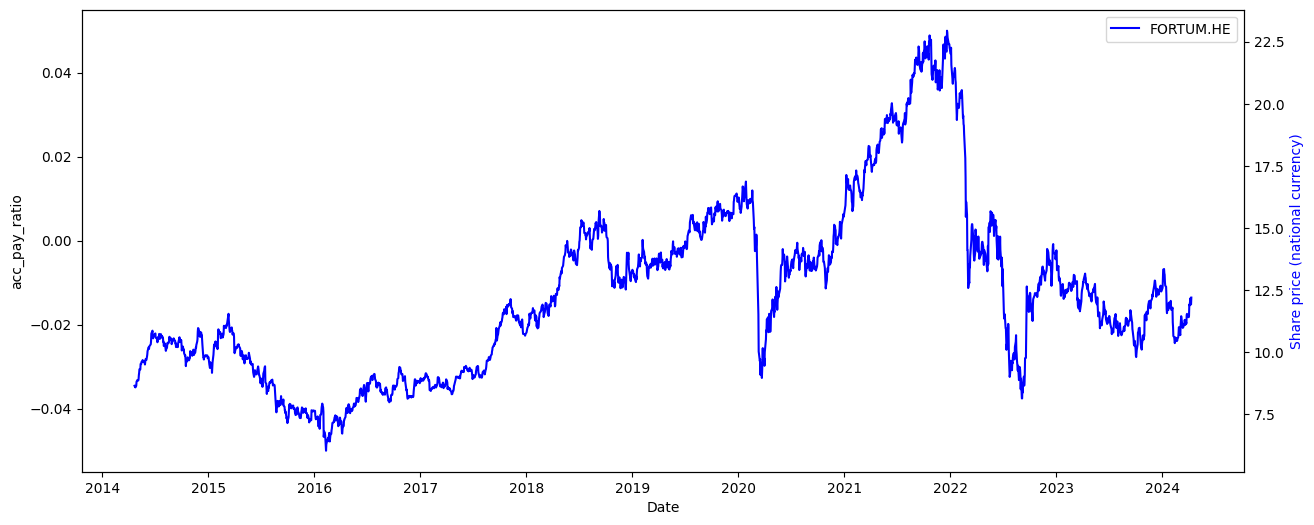

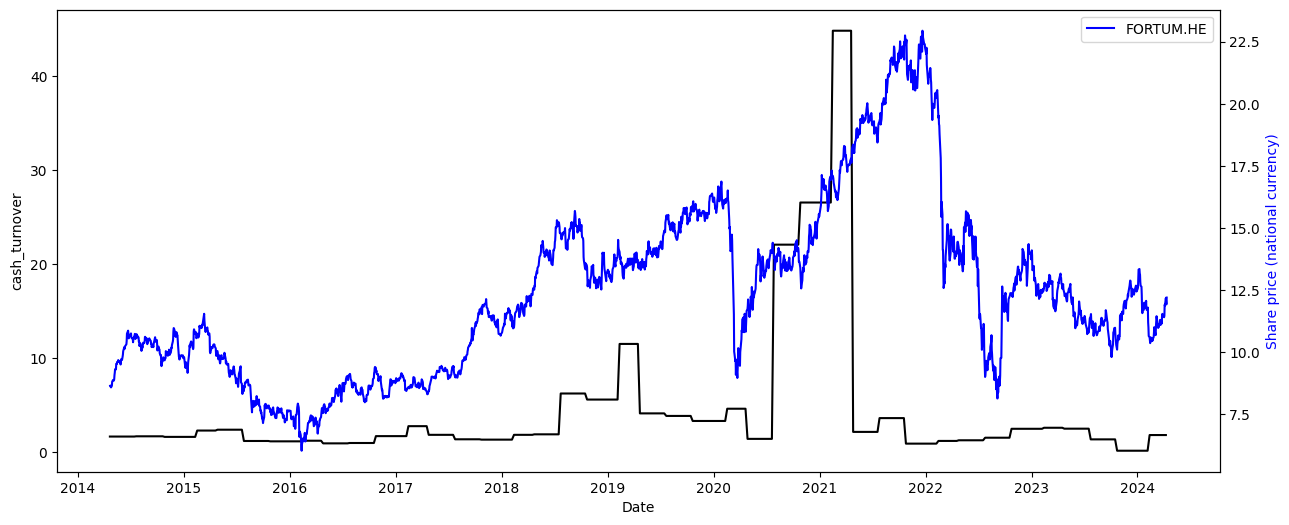

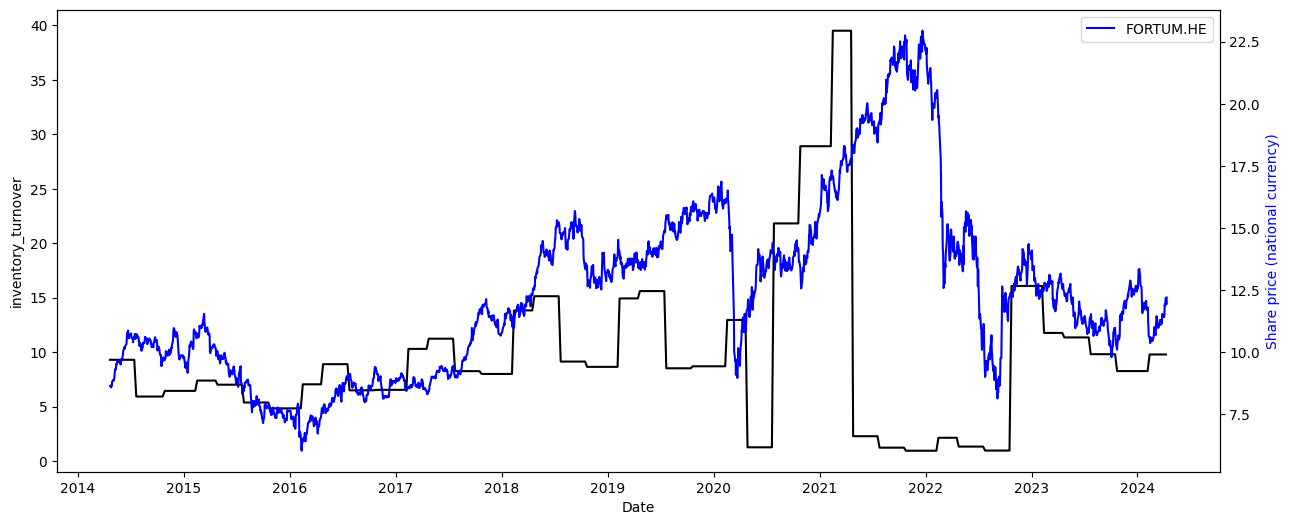

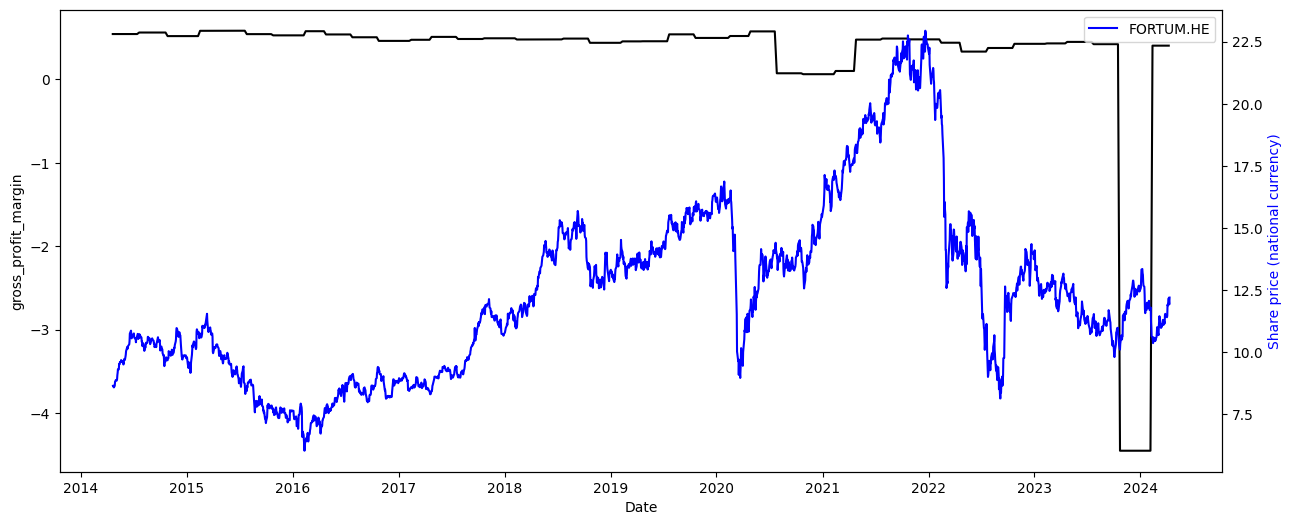

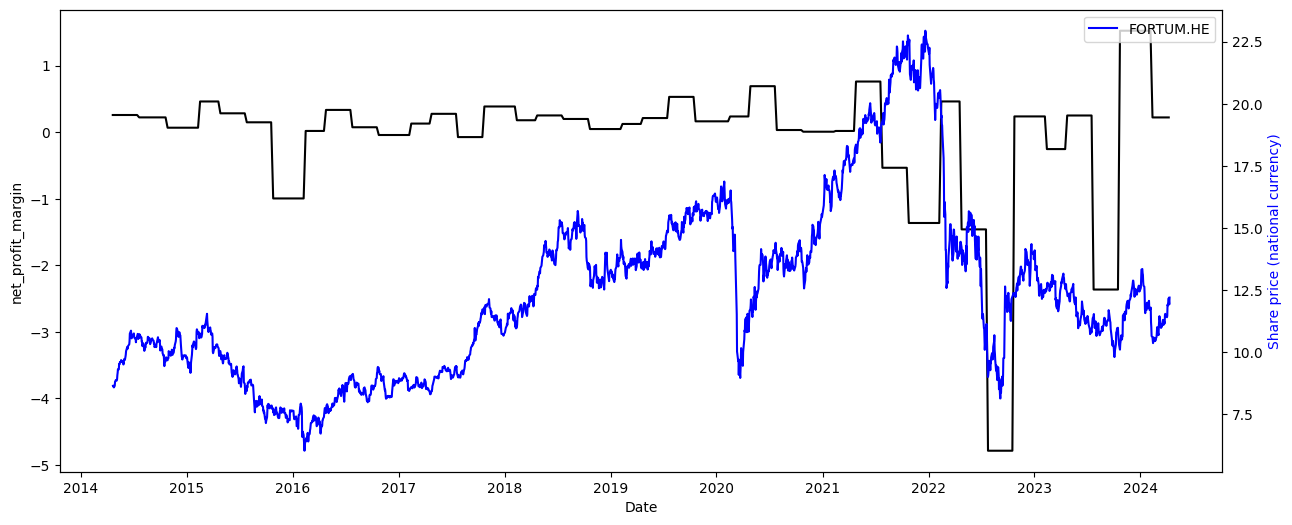

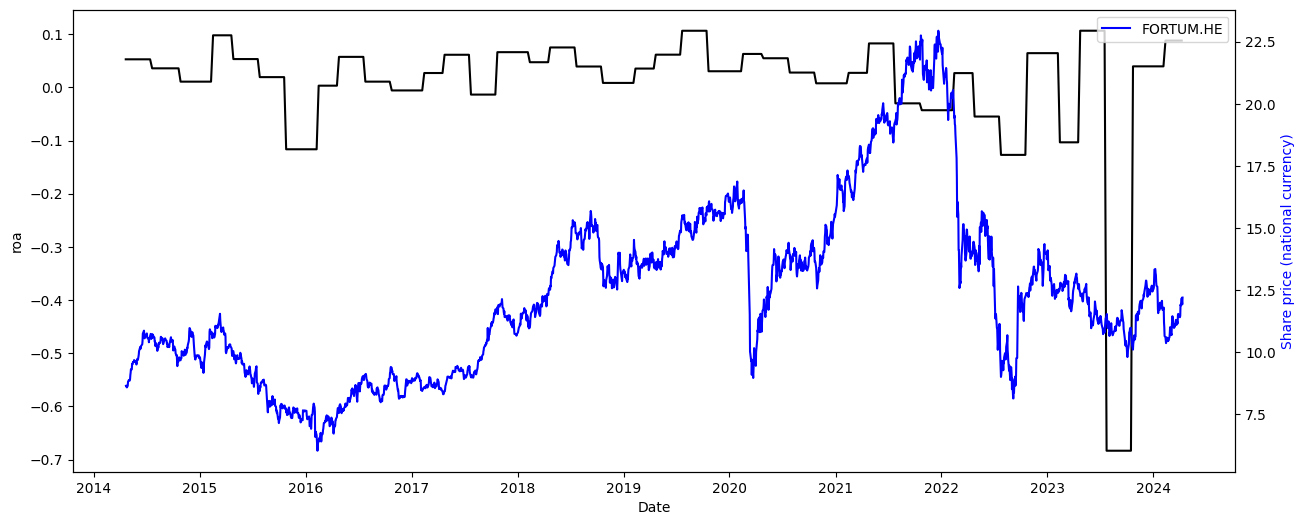

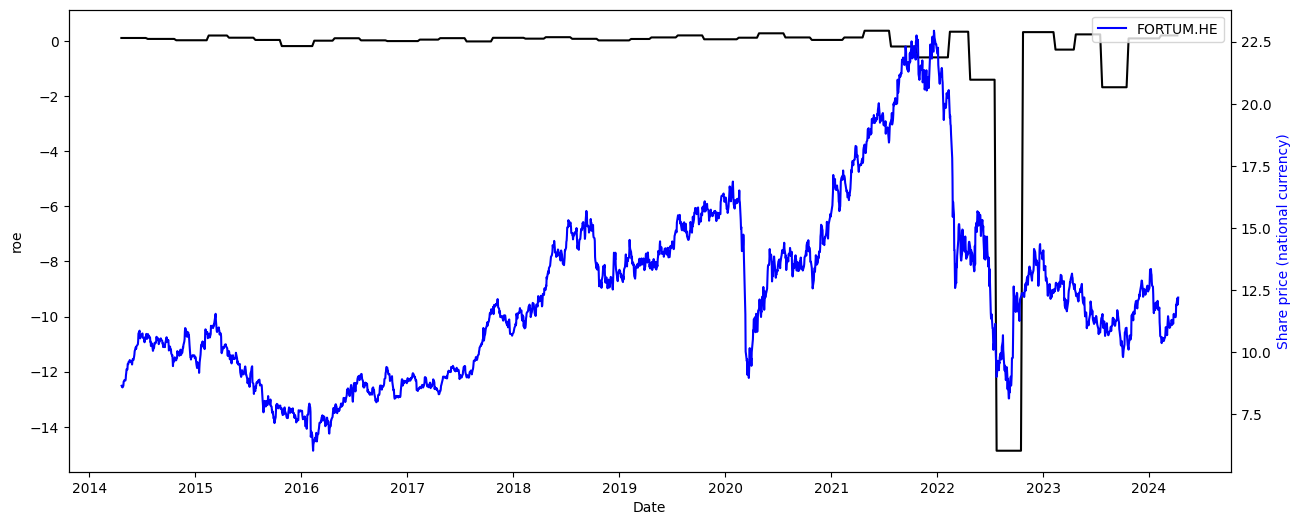

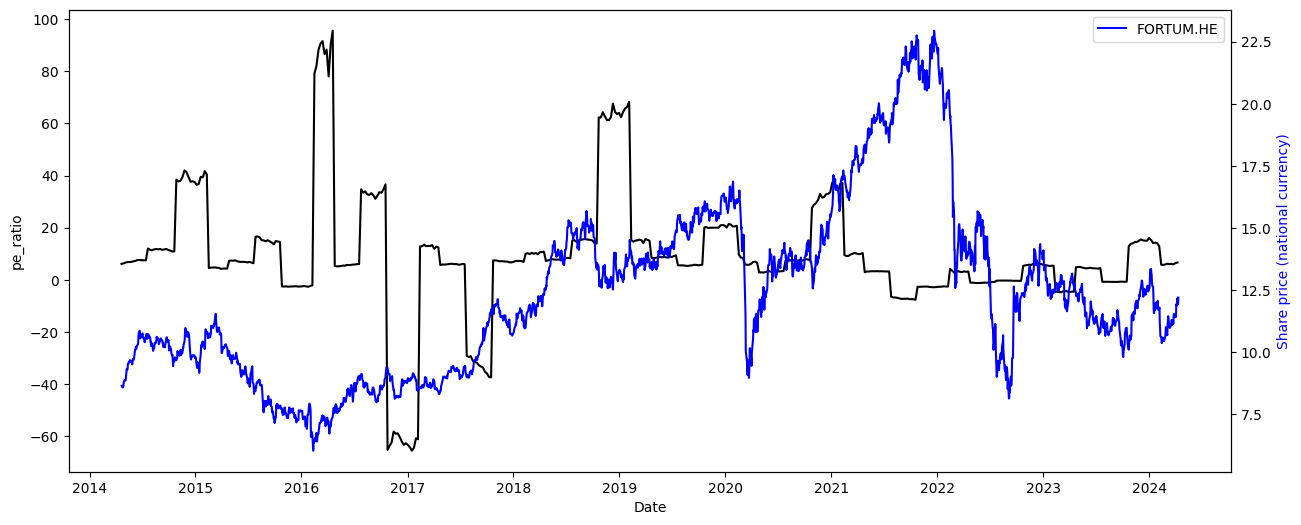

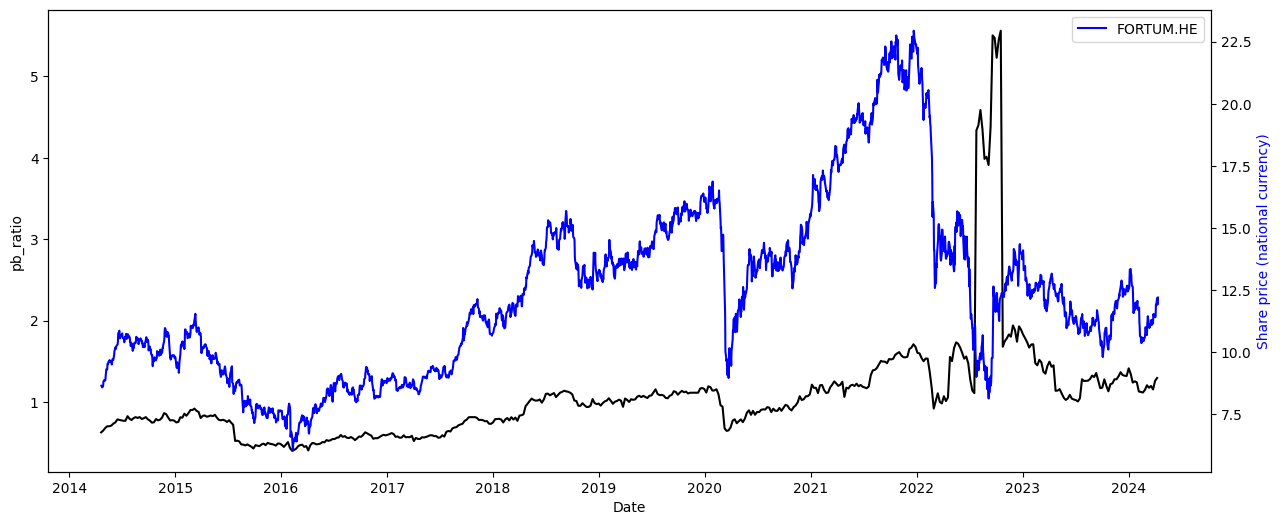

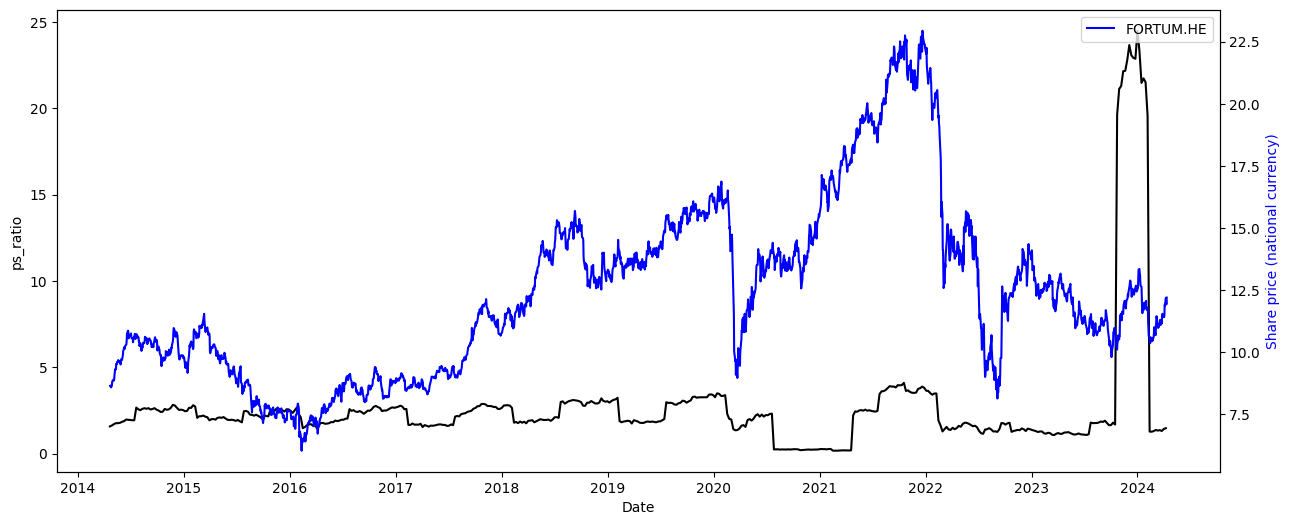

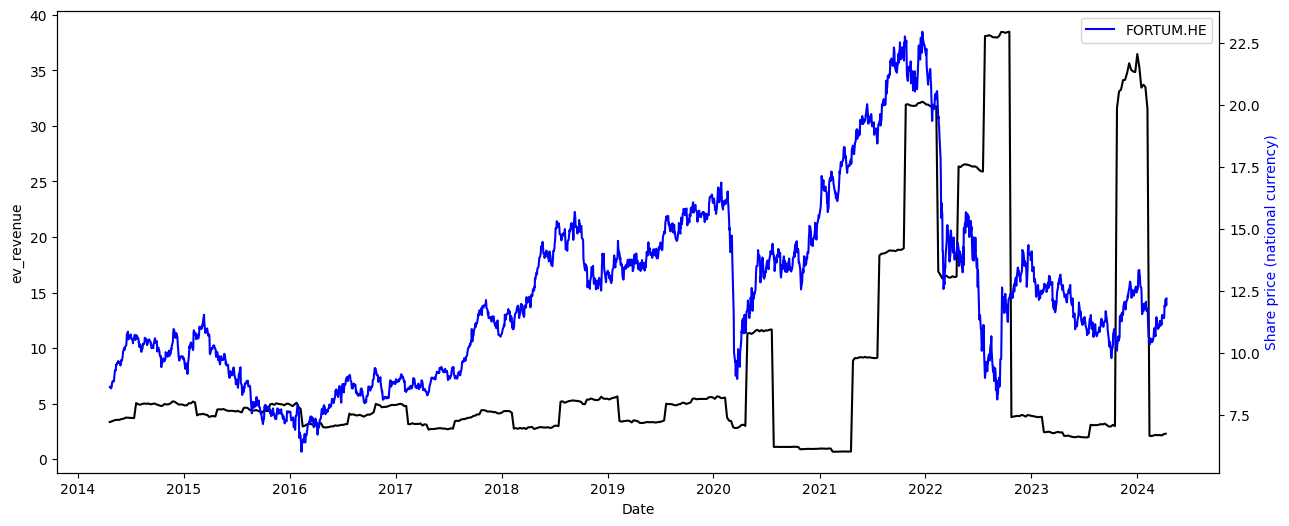

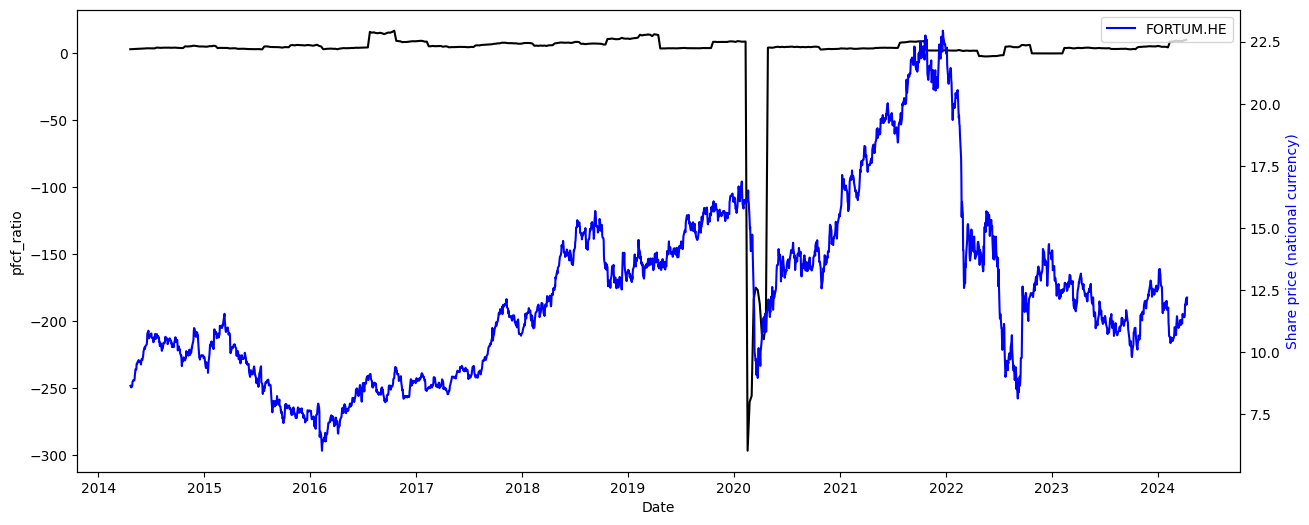

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

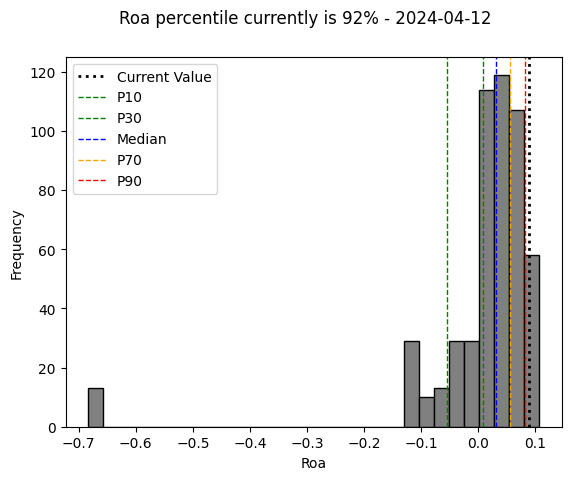

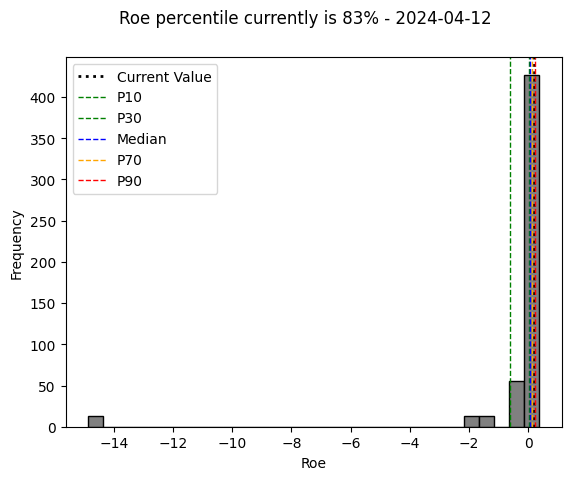

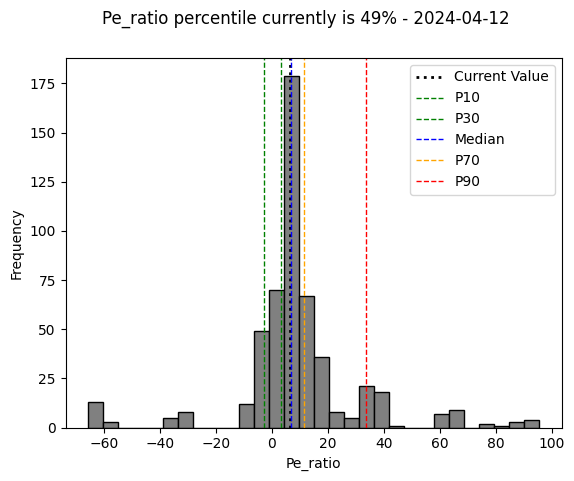

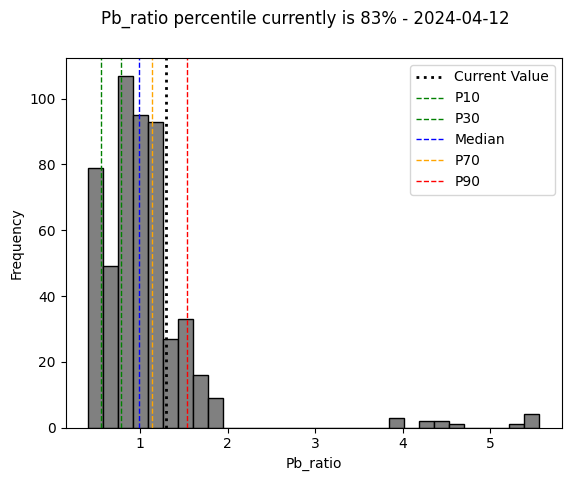

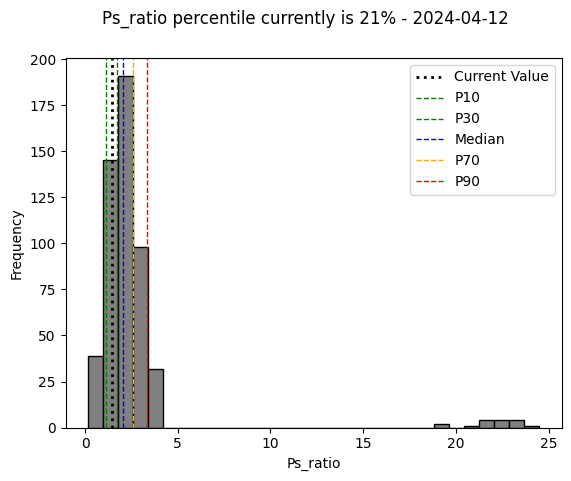

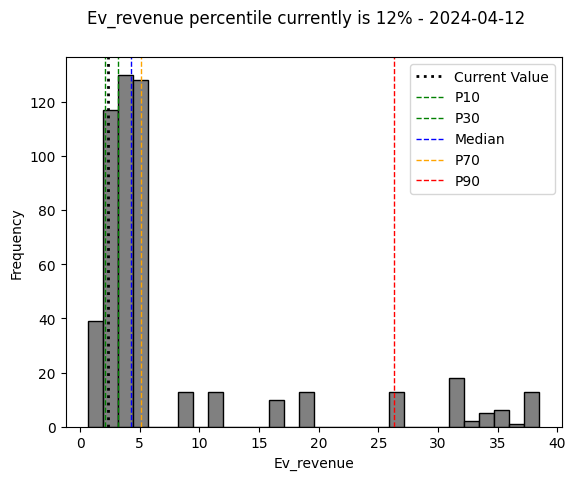

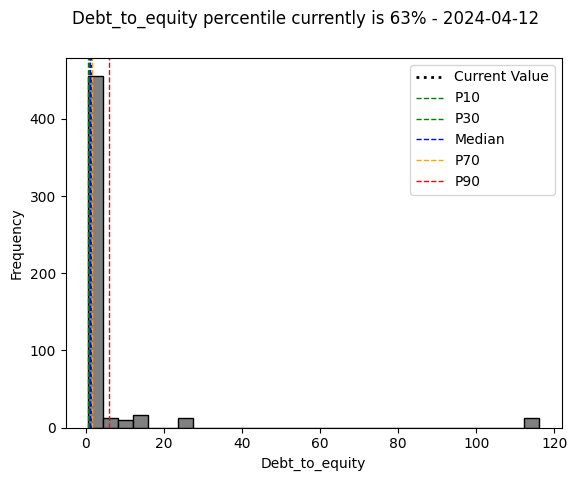

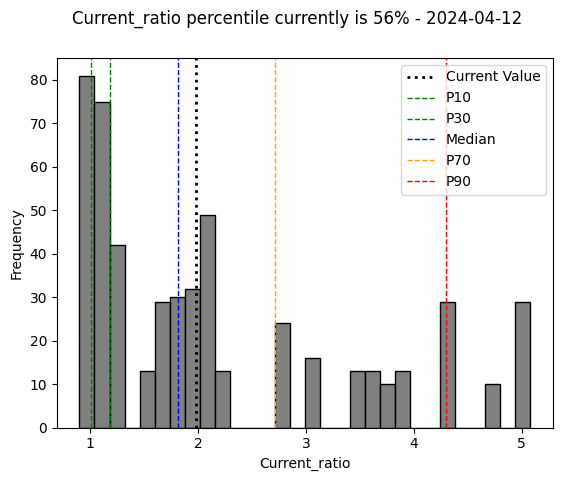

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.305433,0.116059,-0.215641,0.049581,-0.124750,-0.192854,-0.021204
roe,0.305433,1.000000,0.086691,-0.869098,0.057243,-0.550327,-0.978097,0.173285
pe_ratio,0.116059,0.086691,1.000000,-0.091567,0.027227,-0.129299,-0.096558,-0.070785
pb_ratio,-0.215641,-0.869098,-0.091567,1.000000,0.037053,0.638707,0.894405,-0.520809
ps_ratio,0.049581,0.057243,0.027227,0.037053,1.000000,0.535124,-0.065603,0.008149
ev_revenue,-0.124750,-0.550327,-0.129299,0.638707,0.535124,1.000000,0.629498,-0.323903
debt_to_equity,-0.192854,-0.978097,-0.096558,0.894405,-0.065603,0.629498,1.000000,-0.257623
current_ratio,-0.021204,0.173285,-0.070785,-0.520809,0.008149,-0.323903,-0.257623,1.000000


9 timestemos have been found!


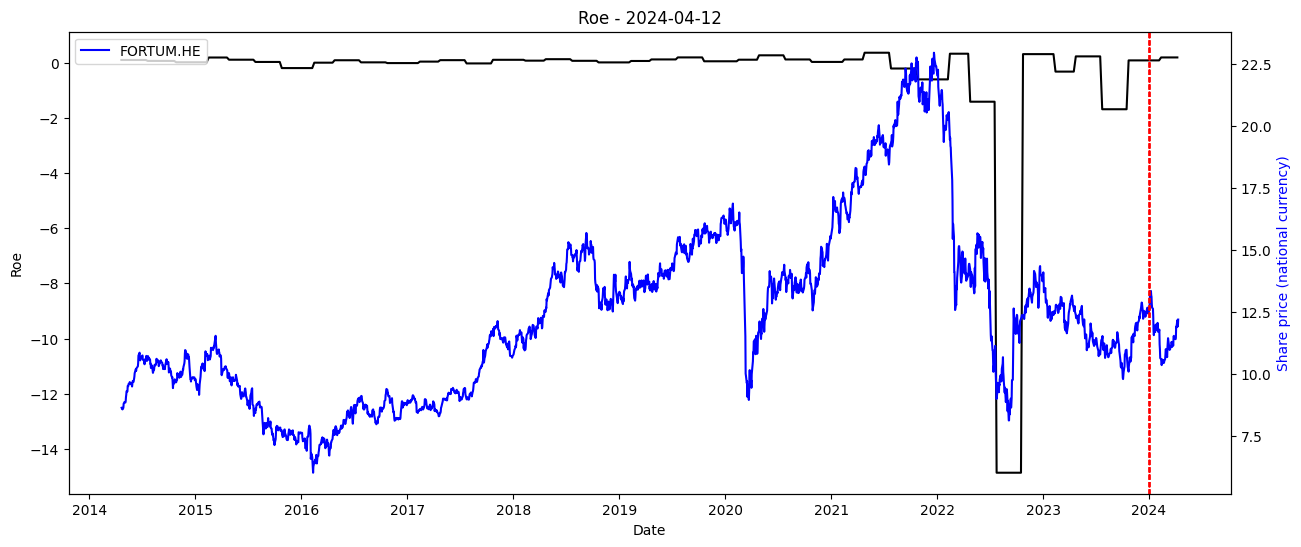

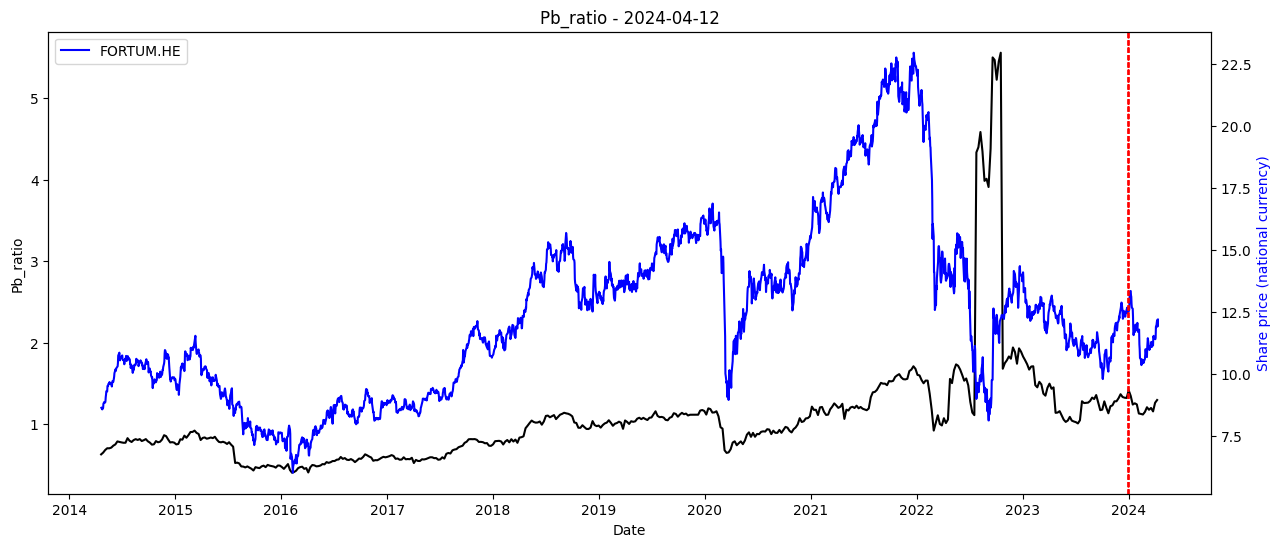

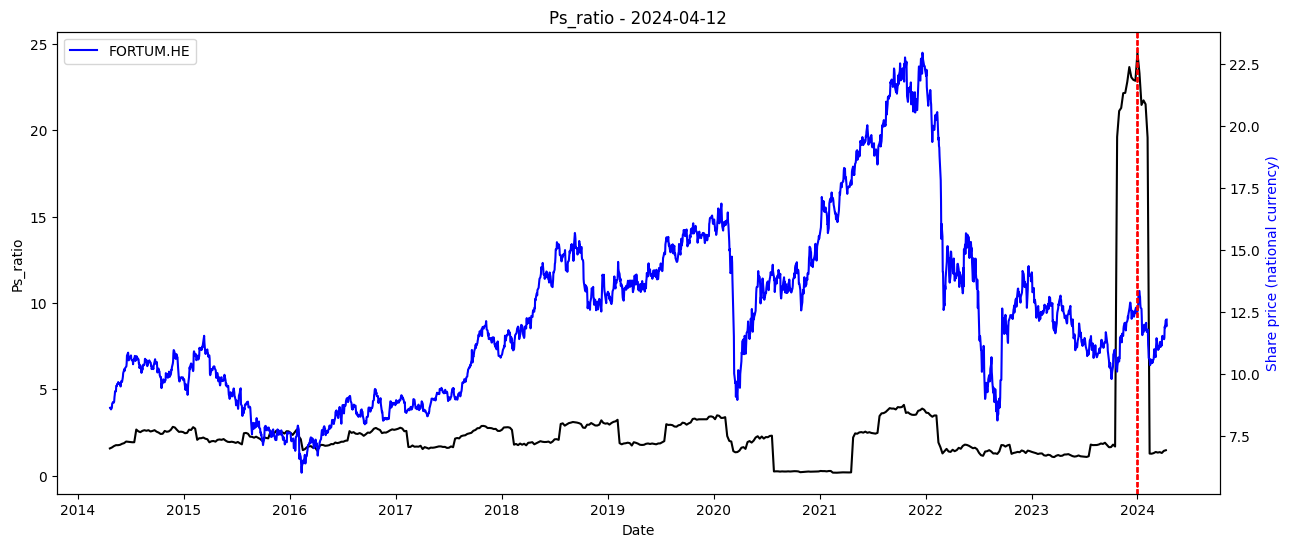

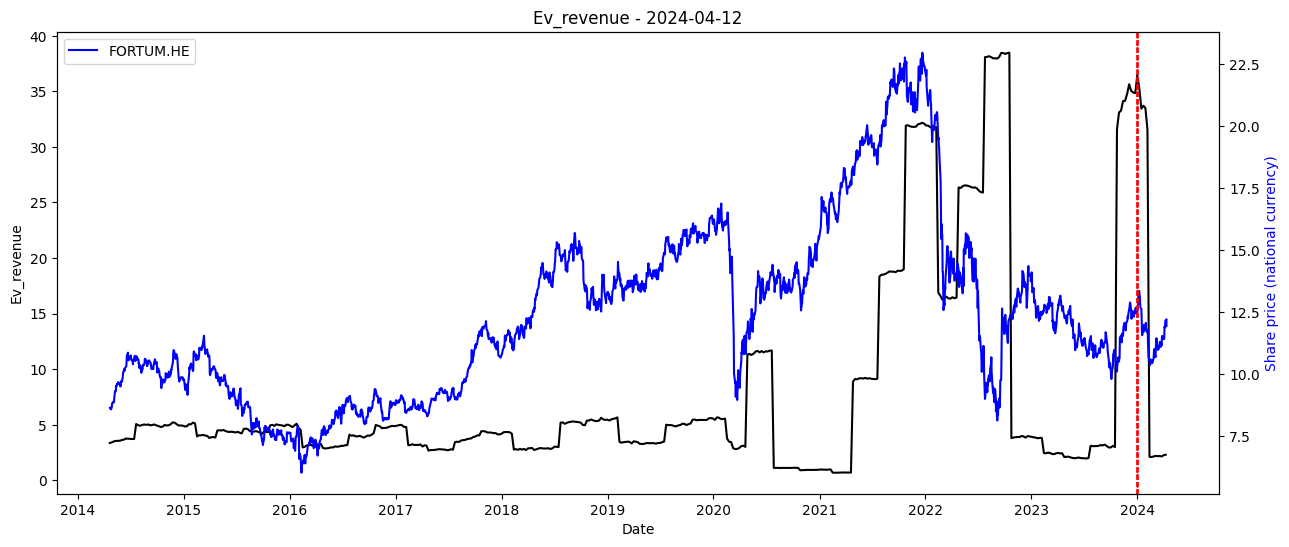

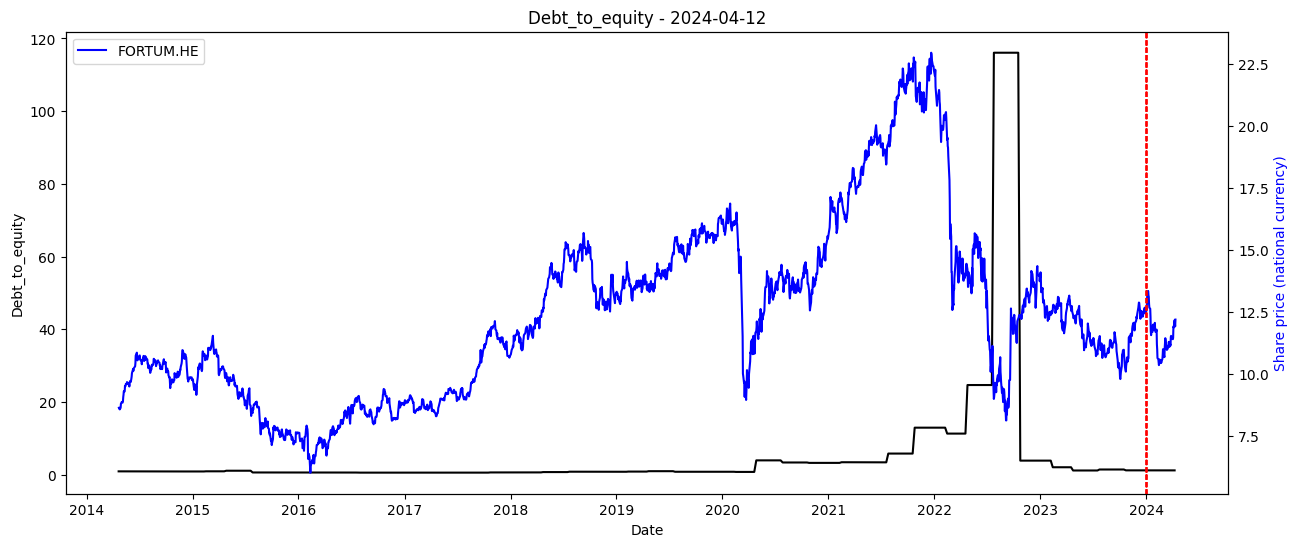

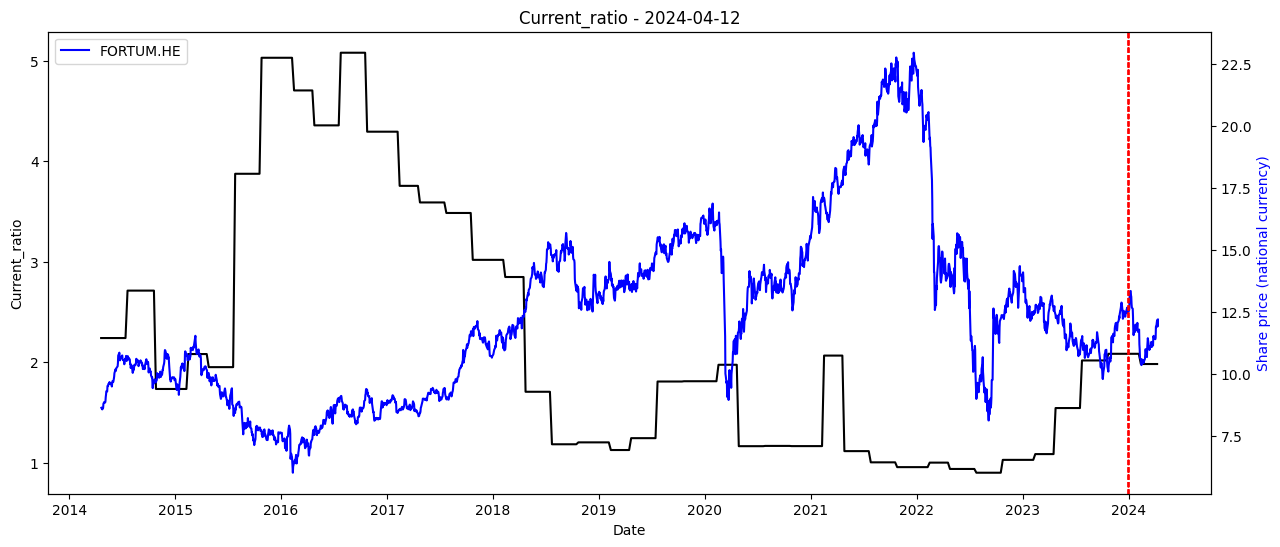

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )